<b>
    The last phase of the Hands-on will be focused on performing a functional enrichment analysis in order to understand the pathways that are significantly enriched in our sets of genes.
For doing this we will exploit g:Profiler a toolset for finding biological categories that are enriched in gene lists by mapping it to known functional information sources such as <a href='http://geneontology.org/'>Gene Ontology (GO)</a>, <a href='https://www.genome.jp/kegg/'> Kyoto Encyclopedia of Genes and Genomes (KEGG) </a> etc. in order to detect statistically significant enriched biological processes, pathways, regulatory motifs and protein complexes.
To evaluate the significance of the pathways enriched it implement the hypergeometric test that describes the probability of k successes (random draws for which the object drawn belongs to a pathway) in n draws, without replacement, from a finite population of size N that contains exactly K objects. Then in order to reducing the amount of false positive findings it performs multiple testing correction.
<\b>

In [22]:
from gprofiler import GProfiler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
gp = GProfiler(return_dataframe=True)

In [23]:
Guild_Out=pd.read_csv('../NetworkPropagation/Guild_Outputs/output_NetScore',sep='\t',names=['entrez','score'])
Nodes=pd.read_csv('../NetworkPropagation/nodes.sif',sep=' ',names=['entrez','score'])
#Seeds are in the nodes file but have score==1
Seeds=Nodes[Nodes.score==1]
#Keep the 1% of the output
Guild_Out_top=Guild_Out.iloc[-int(Guild_Out.shape[0]*0.01):]
#Keep just the genes prioritized from the algorithm the symbol "~" means not
OutputNoseeds=Guild_Out_top[~Guild_Out_top.entrez.isin(Seeds.entrez.tolist())]

In [24]:
enrichment_noseeds=gp.profile(organism='hsapiens',
            query=OutputNoseeds.entrez.tolist(),
                                  significance_threshold_method='bonferroni',
                                  no_iea=True)

In [25]:
enrichment_noseeds

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,REAC,REAC:R-HSA-375276,Peptide ligand-binding receptors,7.118838e-23,True,Peptide ligand-binding receptors,195,78,25,10760,0.320513,0.128205,query_1,[REAC:R-HSA-373076]
1,REAC,REAC:R-HSA-373076,Class A/1 (Rhodopsin-like receptors),3.225609e-17,True,Class A/1 (Rhodopsin-like receptors),328,78,25,10760,0.320513,0.076220,query_1,[REAC:R-HSA-500792]
2,REAC,REAC:R-HSA-380108,Chemokine receptors bind chemokines,3.125887e-16,True,Chemokine receptors bind chemokines,57,78,14,10760,0.179487,0.245614,query_1,[REAC:R-HSA-375276]
3,REAC,REAC:R-HSA-500792,GPCR ligand binding,8.514601e-15,True,GPCR ligand binding,459,78,26,10760,0.333333,0.056645,query_1,[REAC:R-HSA-372790]
4,KEGG,KEGG:04061,Viral protein interaction with cytokine and cy...,3.463644e-14,True,Viral protein interaction with cytokine and cy...,98,62,15,8014,0.241935,0.153061,query_1,[KEGG:00000]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,GO:CC,GO:0005615,extracellular space,3.908107e-02,True,"""That part of a multicellular organism outside...",3237,95,33,17081,0.347368,0.010195,query_1,"[GO:0005576, GO:0110165]"
125,CORUM,CORUM:1972,BMP4-BGN complex,4.461574e-02,True,BMP4-BGN complex,2,9,1,3627,0.111111,0.500000,query_1,[CORUM:0000000]
126,GO:CC,GO:0005778,peroxisomal membrane,4.544151e-02,True,"""The lipid bilayer surrounding a peroxisome."" ...",54,95,4,17081,0.042105,0.074074,query_1,"[GO:0005777, GO:0031903]"
127,GO:CC,GO:0031903,microbody membrane,4.544151e-02,True,"""The lipid bilayer surrounding a microbody."" [...",54,95,4,17081,0.042105,0.074074,query_1,"[GO:0042579, GO:0098588]"


In [26]:
def plot_enrichment_analisys_1(df,p_value,figsize=(15,10),size_factor=80):
    cmap = plt.get_cmap("tab10")
    colors=cmap(np.arange(len(df.source.value_counts())))
    
    for i, (s,v) in enumerate(zip(df.source.value_counts().index,df.source.value_counts())):
        y= list(reversed(-np.log10(list(filter(lambda x: -np.log10(x)>=p_value,df[df.source==s].p_value.tolist())))))
        x=list(reversed(df[(df.source==s) & (-np.log10(df.p_value)>p_value)].name.tolist()))
        sizes=[si for si in df[(df.source==s) & (-np.log10(df.p_value)>=p_value)].intersection_size.tolist()]
        if len(y)==0:
            continue
        else:
            fig,ax=plt.subplots(figsize=figsize)
            scat=ax.scatter(y,x,color=colors[i],alpha=0.4,s=[size_factor*s for s in sizes])
            ax.set_xlabel('$-\log_{10}(p-value)$',fontsize=15)
            ax.set_yticks([int(l) for l in ax.get_yticks()])
            ax.set_title(s,fontsize=20)
            

            ax.spines['bottom'].set_color(colors[i])
            ax.spines['left'].set_color(colors[i])
            ax.spines['bottom'].set_linewidth(4)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.grid(color=colors[i], linestyle='-', linewidth=2,alpha=0.05)
            ax.tick_params(direction='out',which= 'major' ,length=8, width=2, left=False,labelsize=20)
            
            handles, labels = scat.legend_elements(prop='sizes',alpha=0.6)
            lab=[int(re.search('\d+',l).group(0))//size_factor for l in labels] 
            
            legend_markers=(handles[0],handles[len(handles)//2],handles[-1])
            legend_labels=(lab[0],lab[len(handles)//2],lab[-1])
                        
            leg = ax.legend(legend_markers, legend_labels, 
                            loc="lower right", 
                            title="Number of Genes",
                            prop={'size': 30},
                            title_fontsize=20,
                           ncol=2,
                           markerscale=0.8)
            
            
            [hand.set_color(colors[i]) for hand in leg.legendHandles]
            plt.show()
            

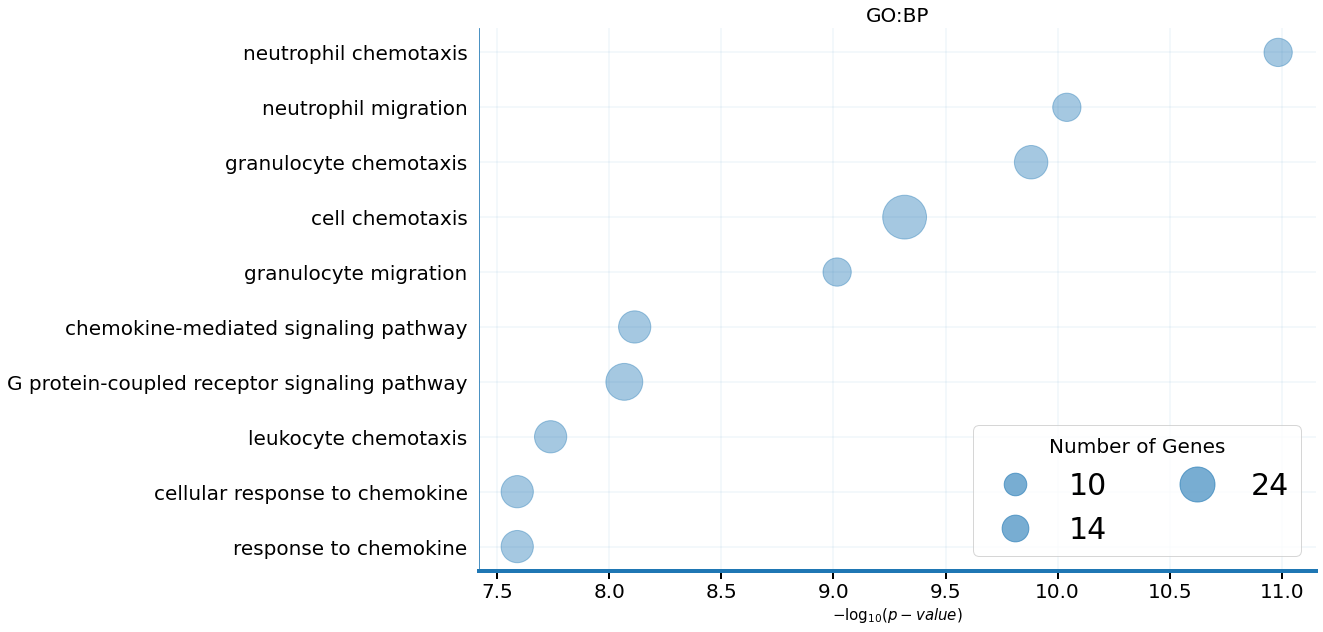

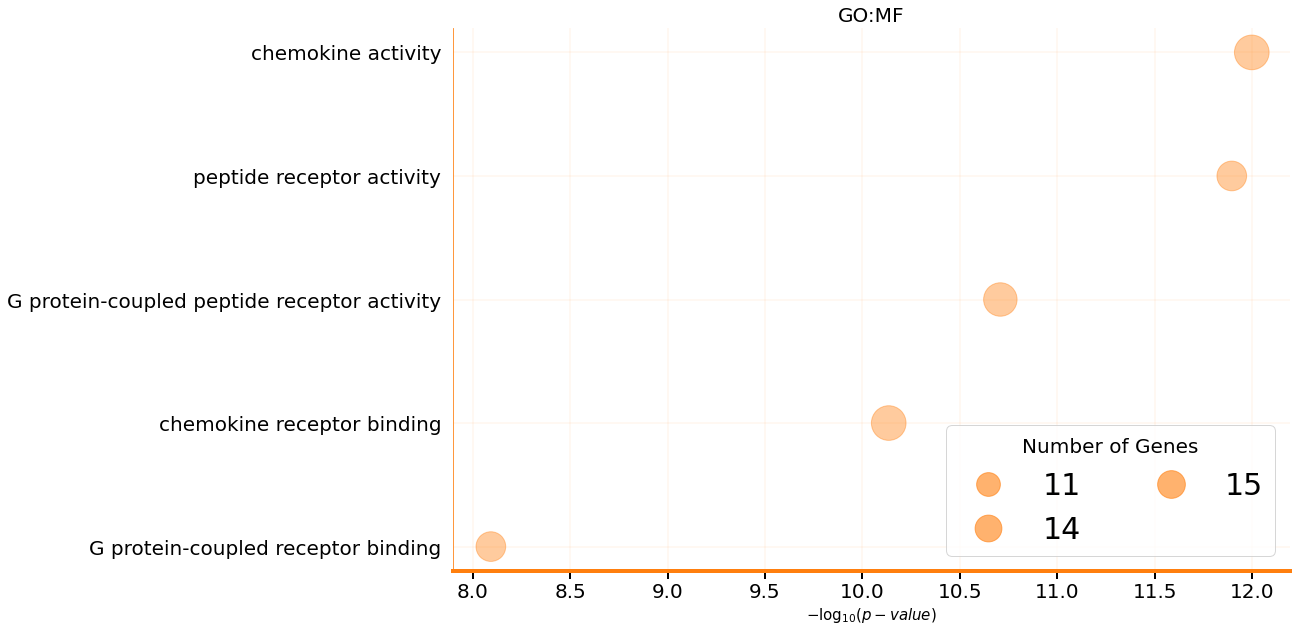

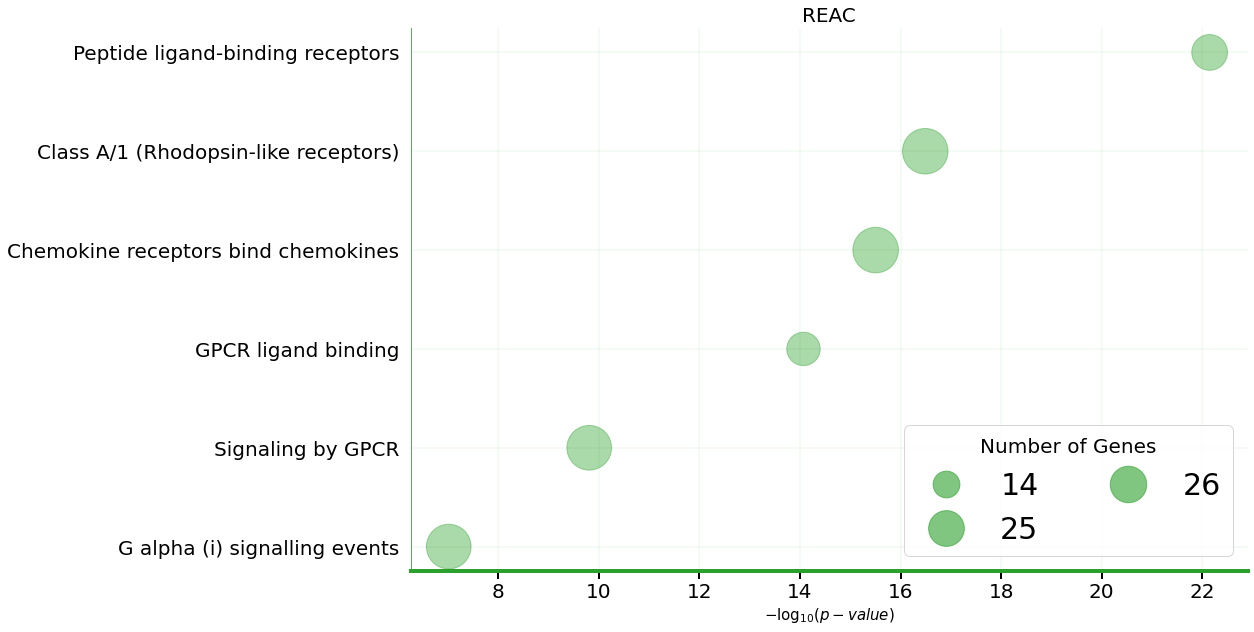

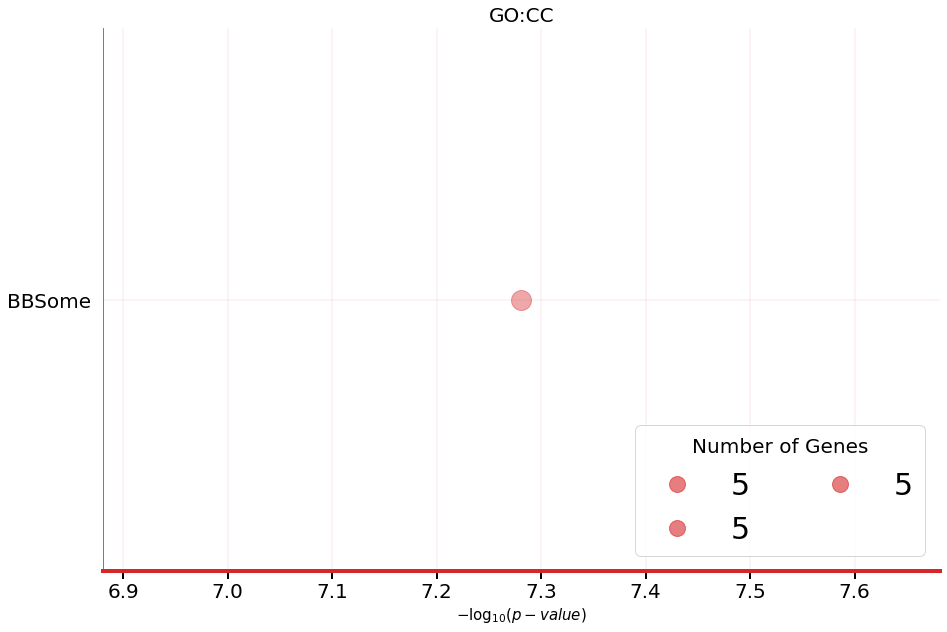

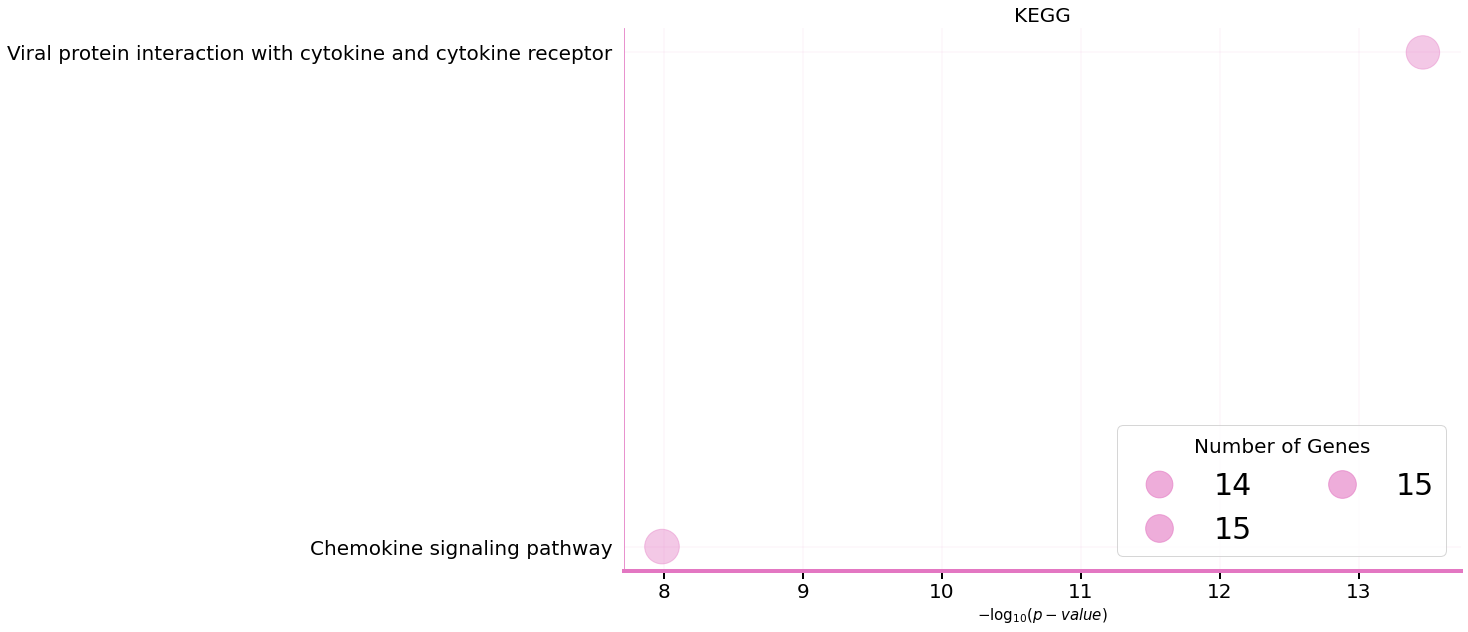

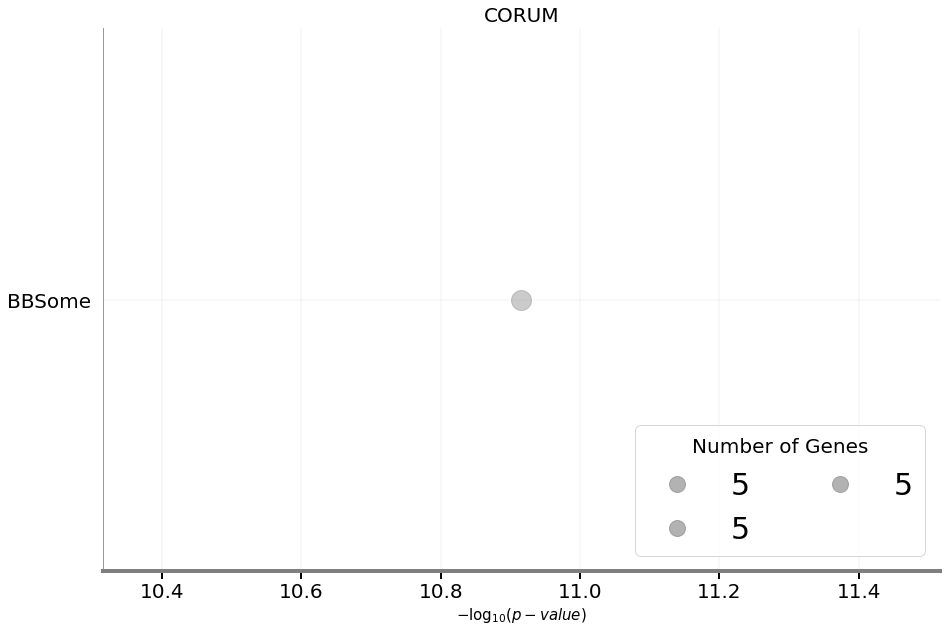

In [33]:
plot_enrichment_analisys_1(enrichment_noseeds,7)